In [4]:
import numpy as np
import pandas as pd
import gurobipy as gp
import math
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.stats import ortho_group
plt.rcParams['font.family'] = 'Times New Roman' # font familyの設定
plt.rcParams['mathtext.fontset'] = 'stix' # math fontの設定
plt.rcParams["font.size"] = 15 # 全体のフォントサイズ


In [5]:
import plotly.graph_objects as go

In [6]:
import LCP_FS   # Facchinei and Soares
import LCP_FW   # Frank-Wolfe
import LCP_FISTA  # Nesterov
import LCP_DCA  # DCA
import LCP_DCAE # DCA Eig
import LCP_DCAT # DCA Tri

import importlib
importlib.reload(LCP_FS)
importlib.reload(LCP_FW)
importlib.reload(LCP_FISTA)
importlib.reload(LCP_DCA)
importlib.reload(LCP_DCAE)
importlib.reload(LCP_DCAT)

<module 'LCP_DCAT' from 'C:\\Users\\TAKALA\\Documents\\DTA\\work\\20210803_LCP\\LCP_DCAT.py'>

| ケース | $M$ | $b$ | 固有値 |
|:-: | :-: |:-: |:-:|
|1| $ \begin{bmatrix} -1 & -1 \\ 0 & 1 \end{bmatrix}$ | $ \begin{bmatrix} 2 \\ 1  \end{bmatrix}$ | $ \begin{bmatrix} -1 \\ 1  \end{bmatrix}$ |
||

In [8]:
class A1:
    def coef(self, n):
        M = np.array([[0, -1, 2], [2, 0, -2], [-1, 1, 0]])
        q = np.array([3, -6, 1])
        return M, q
    
    def evaluate(self, x):
        n = x.size
        M, q = self.coef(n)
        ret = np.dot(x, M@x) + q.T@x
        return ret

        
    def problem_name(self):
        return "LCP1"
    
M, b = A1().coef(3)

In [17]:
N = 2

M_dic = {}

case = 1
M_dic[case] = {}
M_dic[case]['M'] = np.array([[-1.0, -1.0],
                          [0.0, 1.0]])
M_dic[case]['b'] = np.array([2.0, 1.0])


case = 2
M_dic[case] = {}
M_dic[case]['M'] = np.array([[-1.0, -1.0],
                          [-1.0, -2.0]])
M_dic[case]['b'] = np.array([1.0, 1.0])


case = 3
M_dic[case] = {}
M_dic[case]['M'], M_dic[case]['b'] = A1().coef(3)

In [20]:
tr_case = 3
M = M_dic[tr_case]['M']
b = M_dic[tr_case]['b']
np.linalg.eigvals(M)

array([-0.16374+2.46585327j, -0.16374-2.46585327j,  0.32748+0.j        ])

In [21]:
%%time
# Newton method by Facchinei and Soares
FS_model = LCP_FS.model(M, b)
FS_x, FS_merit = FS_model.solve(err=10**(-6), max_itr=100)

Wall time: 3 ms


In [22]:
%%time
importlib.reload(LCP_FW)
# Frank-wolfe method
FW_model = LCP_FW.model(M, b)
FW_x, FW_x_list = FW_model.solve(err=10**(-6), max_itr=100)

Wall time: 5 ms


In [23]:
FW_x

array([3., 3., 0.])

In [59]:
%%time
importlib.reload(LCP_FISTA)
# Nesterov-accelerated-gradient-descent for the merit function (M)
FISTA_M_model = LCP_FISTA.model(M, b)
FISTA_M_x, FISTA_M_x_list = FISTA_M_model.solve_M(err=10**(-6), L=0.001, max_itr=100)

Restart
Restart
Restart
Restart
Restart
Restart
Restart
Restart
Restart
Restart
Restart
Restart
Restart
Restart
Restart
Restart
Wall time: 188 ms


In [60]:
print(FW_x)
print(FS_x)
print(FISTA_M_x)

[3. 3. 0.]
[3. 3. 0.]
[3.000e+00 2.000e+00 4.996e-16]


In [58]:
FISTA_M_model.MngMerit(np.array([3,2,0]))
FISTA_M_model.MngMerit(np.array([3,3,0]))

0.0

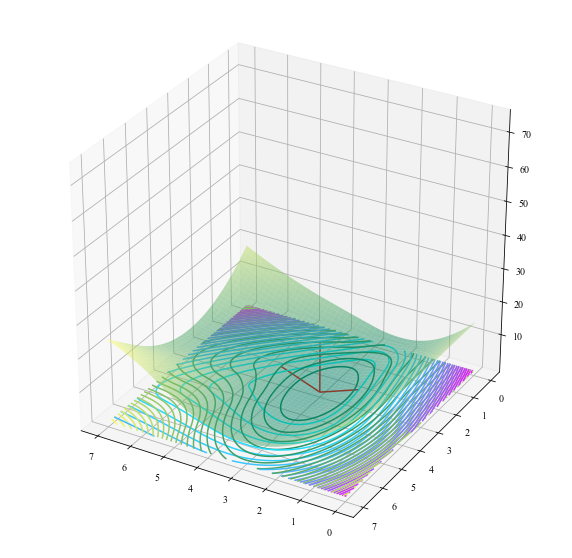

In [29]:
%matplotlib inline

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')


T = 200
R = FW_x.max()*2+1
x = y = np.linspace(0, R,T)
X, Y = np.meshgrid(x, y)


z = np.zeros(shape=(T,T))
zm = np.zeros(shape=(T,T))

for i in range(T):
    for j in range(T):
        z[j,i] = FS_model.Psi(np.array([x[i], y[j], 0]))
        zm[j,i] = FISTA_M_model.MngMerit(np.array([x[i], y[j], 0]))

        

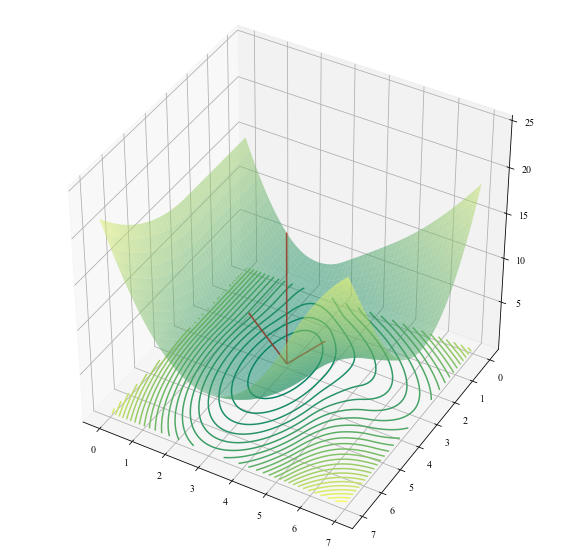

In [46]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')



ax.plot_surface(X,Y,zm, cmap = 'summer', alpha=0.5)
# ax.plot_surface(X,Y,z, cmap = 'bwr', alpha=0.5)


ax.quiver(FW_x[0], FW_x[1], z.max()*0.2, 0,0,-z.max()*0.2, color='red')
# ax.quiver(FS_x[0], FS_x[1], z.max()*0.2, 0,0,-z.max()*0.2, color='red')

# ax.contour(X, Y, z, zdir='z', offset=0, cmap = 'cool', levels=30)
ax.contour(X, Y, zm, zdir='z', offset=0, cmap = 'summer', levels=30)

ax.view_init(elev=40, azim=120)

ax.invert_xaxis()
ax.plt.

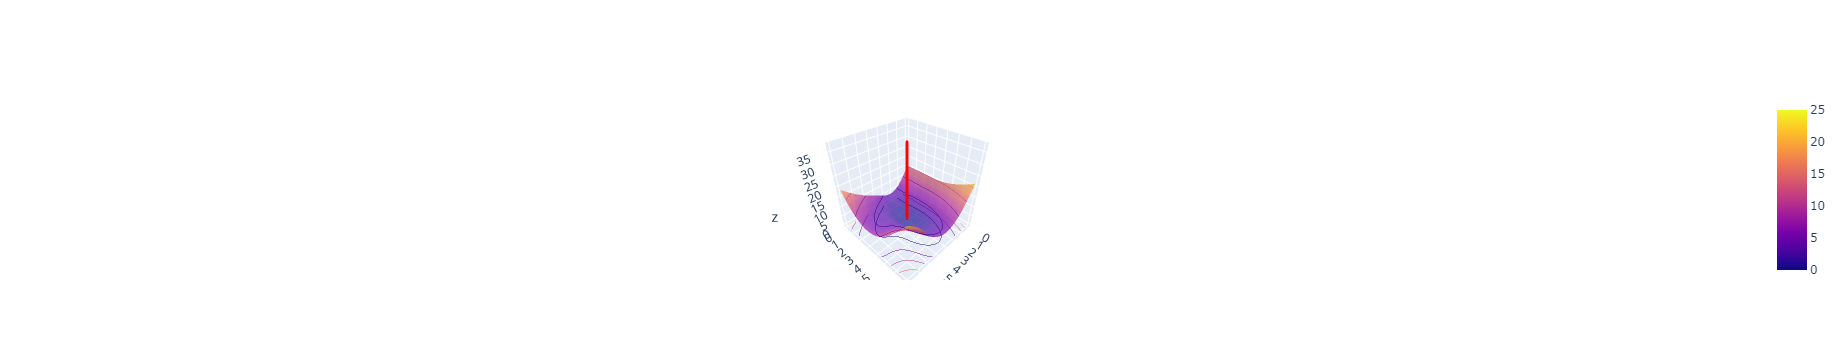

In [49]:

vector = go.Scatter3d( x = [FW_x[0],FW_x[0]],
                       y = [FW_x[1],FW_x[1]],
                       z = [0,z.max()*0.5],
                       marker = dict( size = 1,
                                      color = "red"),
                       line = dict( color = "red",
                                    width = 6)
                     )

surface = go.Surface(
    x=X,
    y=Y,
    z=zm,
    opacity = .7
)

fig = go.Figure(data=[surface])


# tight layout
# fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.update_layout(scene_aspectmode='cube')

fig.update_traces(contours_z=dict(show=True, usecolormap=True, highlightcolor="red", project_z=True))


# surface = go.Surface(
#     x=X,
#     y=Y,
#     z=zm,
#     opacity = .7
# )
# fig.add_traces(data=[surface])

fig.add_traces(data=[vector])

fig.write_html("Mangasarian.html") #Modifiy the html file
fig.show()
